In [1]:
# Importamos las librerías necesarios
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Flatten, Dense, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Concatenate
from keras.utils import image_dataset_from_directory, array_to_img, load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
from sklearn.model_selection import train_test_split
import os, random
from sklearn import preprocessing
from skimage import color
import tensorflow as tf

In [2]:
%cd

C:\Users\Ana Rodriguez


In [3]:
%cd Desktop\MASTER IA\TFM\autoencoder+MLP

C:\Users\Ana Rodriguez\Desktop\MASTER IA\TFM\autoencoder+MLP


In [4]:
# 1. Procesamiento del dataset

In [5]:
import cv2
import os

# Definir la carpeta donde se encuentran las imágenes
carpeta_imagenes = "dataset/normal"

# Obtener la lista de archivos en la carpeta
archivos = os.listdir(carpeta_imagenes)

# Inicializar listas para almacenar las imágenes y las etiquetas
normal = []
etiquetas_normal = []

# Recorrer todos los archivos en la carpeta
for archivo in archivos:
    # Obtener la ruta completa de la imagen
    ruta_imagen = os.path.join(carpeta_imagenes, archivo)
    
    # Cargar la imagen utilizando OpenCV
    img = cv2.imread(ruta_imagen)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
    img_res= cv2.resize(img_rgb, dsize=(256,256),interpolation=cv2.INTER_CUBIC)
    
    
    # Agregar la imagen y la etiqueta a las listas correspondientes
    normal.append(img_res)
    etiquetas_normal.append(0)  # Puedes modificar esta línea para obtener las etiquetas de alguna manera específica


In [6]:
# Definir la carpeta donde se encuentran las imágenes
carpeta_imagenes = "dataset/anomalias"

# Obtener la lista de archivos en la carpeta
archivos = os.listdir(carpeta_imagenes)

# Inicializar listas para almacenar las imágenes y las etiquetas
anomalias = []
etiquetas_anomalias = []

# Recorrer todos los archivos en la carpeta
for archivo in archivos:
    # Obtener la ruta completa de la imagen
    ruta_imagen = os.path.join(carpeta_imagenes, archivo)
    
    # Cargar la imagen utilizando OpenCV
    img = cv2.imread(ruta_imagen)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
    img_res= cv2.resize(img_rgb, dsize=(256,256),interpolation=cv2.INTER_CUBIC)
    
    
    # Agregar la imagen y la etiqueta a las listas correspondientes
    anomalias.append(img_res)
    etiquetas_anomalias.append(1)  # Puedes modificar esta línea para obtener las etiquetas de alguna manera específica


In [7]:
from sklearn.model_selection import train_test_split
import numpy as np

# Concatenar las imágenes normales y las imágenes con anomalías
X = np.concatenate((normal, anomalias), axis=0)

# Crear una variable y que contenga las etiquetas para las imágenes normales y las imágenes con anomalías
y = np.concatenate((etiquetas_normal, etiquetas_anomalias), axis=0)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Comprobación de las dimensiones de los conjuntos de datos
print('Tamaño de X_train:', X_train.shape)
print('Tamaño de y_train:', y_train.shape)
print('Tamaño de X_val:', X_val.shape)
print('Tamaño de y_val:', y_val.shape)
print('Tamaño de X_test:', X_test.shape)
print('Tamaño de y_test:', y_test.shape)

Tamaño de X_train: (2627, 256, 256, 3)
Tamaño de y_train: (2627,)
Tamaño de X_val: (657, 256, 256, 3)
Tamaño de y_val: (657,)
Tamaño de X_test: (821, 256, 256, 3)
Tamaño de y_test: (821,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


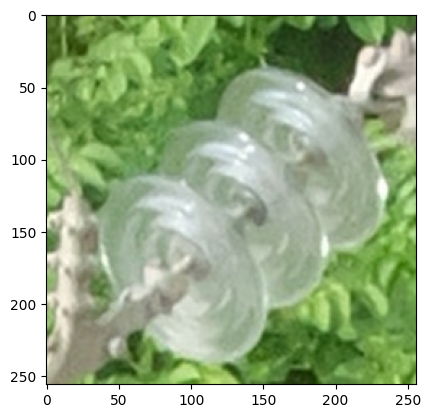

La clase es: 0


In [8]:
plt.imshow(X_train[23])
plt.show()
print('La clase es:', y_train[23])

In [9]:
# Arquitectura autoencoder + MLP

In [10]:
from keras import layers

In [11]:
input_img = Input(shape=(256,256,3)) 
#ENCODER
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
z = MaxPooling2D((2, 2), padding='same')(x)

encoded= Flatten()(z)

# Perceptrón Multicapa en el Espacio Latente

classificaction_layer = Dense(64, activation='relu')(encoded)
classificaction_layer = BatchNormalization(axis=-1)(classificaction_layer)
classificaction_layer = Dropout(0.5)(classificaction_layer)
classificaction_layer = Dense(32, activation='relu')(classificaction_layer)
classificaction_layer = BatchNormalization(axis=-1)(classificaction_layer)
classificaction_layer = Dropout(0.5)(classificaction_layer)
classificaction_layer = Dense(16, activation='relu')(classificaction_layer)
classificaction_layer = BatchNormalization(axis=-1)(classificaction_layer)
classificaction_layer = Dropout(0.5)(classificaction_layer)
classification_output = Dense(1, activation='sigmoid', name='class')(classificaction_layer) 

#DECODER 

x = Reshape((16,16,128))(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)


decoded= Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='decoded')(x)



# MODELO COMPLETO
autoencoder = Model(inputs=input_img, outputs=[classification_output, decoded])
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [12]:
autoencoder.compile(optimizer='adam', loss= ['binary_crossentropy','mse'], metrics= ['accuracy'])
historia = autoencoder.fit(X_train, [y_train, X_train], epochs=200, batch_size=32, validation_data=(X_val,[y_val, X_val]))

Epoch 1/200
83/83 [==============================] - 244s 3s/step - loss: 1.0211 - class_loss: 0.9825 - decoded_loss: 0.0386 - class_accuracy: 0.5082 - decoded_accuracy: 0.3885 - val_loss: 0.8245 - val_class_loss: 0.7954 - val_decoded_loss: 0.0290 - val_class_accuracy: 0.3927 - val_decoded_accuracy: 0.3908
Epoch 2/200
83/83 [==============================] - 240s 3s/step - loss: 0.8673 - class_loss: 0.8431 - decoded_loss: 0.0243 - class_accuracy: 0.5386 - decoded_accuracy: 0.4085 - val_loss: 0.7284 - val_class_loss: 0.7127 - val_decoded_loss: 0.0157 - val_class_accuracy: 0.4353 - val_decoded_accuracy: 0.3891
Epoch 3/200
83/83 [==============================] - 239s 3s/step - loss: 0.7962 - class_loss: 0.7798 - decoded_loss: 0.0163 - class_accuracy: 0.5664 - decoded_accuracy: 0.4291 - val_loss: 0.6821 - val_class_loss: 0.6677 - val_decoded_loss: 0.0144 - val_class_accuracy: 0.6438 - val_decoded_accuracy: 0.4737
Epoch 4/200
83/83 [==============================] - 241s 3s/step - loss: 0.

In [13]:
classification_output, reconstructed_images =autoencoder.predict(X_test)

26/26 [==============================] - 23s 871ms/step


In [21]:
print(classification_output[12])

[0.01185361]


In [14]:
y_pred=[]
for i in classification_output:
    if i>0.5:
        i=1
        y_pred.append(i)
    else:
        i=0
        y_pred.append(i)

In [15]:
from sklearn.metrics import classification_report
# Evaluando el modelo de predicción con las imágenes de test
print("[INFO]: Evaluando red neuronal...")

print(classification_report(y_test, y_pred))

[INFO]: Evaluando red neuronal...
              precision    recall  f1-score   support

           0       0.75      0.92      0.82       549
           1       0.69      0.38      0.49       272

    accuracy                           0.74       821
   macro avg       0.72      0.65      0.66       821
weighted avg       0.73      0.74      0.71       821



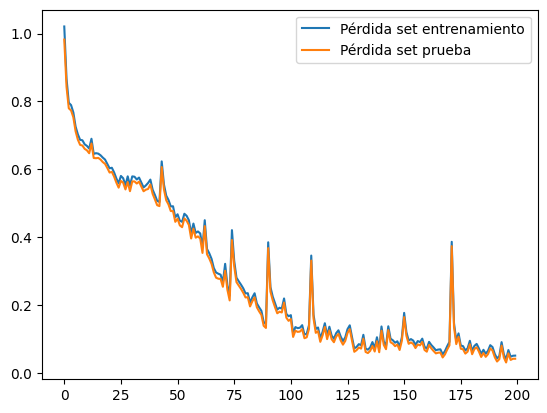

In [17]:
plt.plot(historia.history["loss"], label="Pérdida set entrenamiento")
plt.plot(historia.history["class_loss"], label="Pérdida set prueba")
plt.legend()

In [57]:
# TRANSFER LEARNING- FINE TUNING: VGG16.

In [61]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import imagenet_utils

In [62]:
vgg_model = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(224, 224, 3))

In [64]:
#Preprocesamiento VGG16
X_train = imagenet_utils.preprocess_input(X_train) 
X_test = imagenet_utils.preprocess_input(X_test) 

In [65]:
#Predecir con VGG16

img_path = 'todo_t/train/imagen_39.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

NameError: name 'image' is not defined

In [84]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [73]:
# Congelamos las capas de los 4 primeros bloques convolucionales, el quinto se re-entrena
# En base_model.layers.name tenemos la información del nombre de la capa
for layer in base_model.layers: 
    if layer.name == 'block3_conv1': 
        break 
    layer.trainable = False 
    print('Capa ' + layer.name + ' congelada...') 

Capa input_5 congelada...
Capa block1_conv1 congelada...
Capa block1_conv2 congelada...
Capa block1_pool congelada...
Capa block2_conv1 congelada...
Capa block2_conv2 congelada...
Capa block2_pool congelada...


In [74]:
# Ó Descongelar los ultimos bloques convolucionales
for layer in vgg_model.layers[:15]:
    layer.trainable = False
# Visualizar las capas descongeladas
for i, layer in enumerate(vgg_model.layers):
    print(i, layer.name, layer.trainable)

0 input_4 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [76]:
from tensorflow.keras import regularizers

In [77]:
# Cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-1].output 
x = Flatten()(last) 

x= (layers.Dense(units=128, activation='relu',kernel_regularizer=regularizers.l2(0.3)))(x)
x= (Dropout(0.25))(x)
x= (layers.Dense(units=64, activation='relu',kernel_regularizer=regularizers.l2(0.3)))(x)
x= (Dropout(0.25))(x)
x= (layers.Dense(units=32, activation='relu',kernel_regularizer=regularizers.l2(0.3)))(x)
x= (Dropout(0.25))(x)
x= (layers.Dense(units=16, activation='relu',kernel_regularizer=regularizers.l2(0.3)))(x)
x= (Dropout(0.25))(x)

x= Dense(units=1, activation='sigmoid')(x)

model = Model(base_model.input, x) 
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [81]:
X_train_r= cv2.resize(X_train, dsize=(224,224),interpolation=cv2.INTER_CUBIC)

In [79]:
h=model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
h=model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data= (X_val, y_val))

Epoch 1/100


ValueError: in user code:

    File "C:\Users\Ana Rodriguez\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Ana Rodriguez\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Ana Rodriguez\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Ana Rodriguez\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Ana Rodriguez\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Ana Rodriguez\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 256, 256)


In [ ]:
print("[INFO]: Evaluando red neuronal...")
model.predict(X_test)
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss {}, accuracy {}'.format(loss,accuracy))

[INFO]: Evaluando red neuronal...
13/13 [==============================] - 2s 121ms/step - loss: 0.6593 - accuracy: 0.6295
Loss 0.6592527627944946, accuracy 0.629539966583252


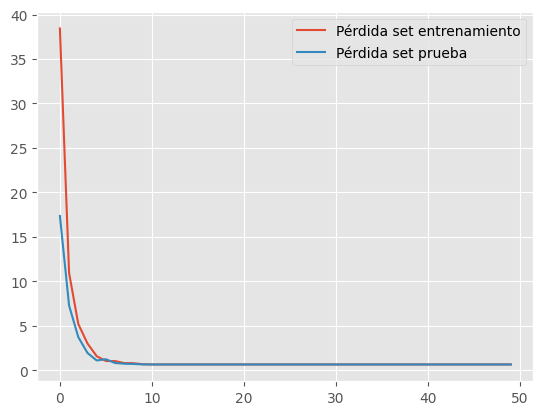

In [182]:
plt.plot(h.history["loss"], label="Pérdida set entrenamiento")
plt.plot(h.history["val_loss"], label="Pérdida set prueba")
plt.legend()